# Initial Setup and Load Data

In [1]:
# Load Libraries
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import re
import string
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

In [2]:
# For maximizing Cell width of Jupyter Notebook Cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Set working directory
os.chdir("/opt/ShadData/NLP/Directi_CaseStudy/")

In [4]:
# For Not Displaying warnings
import warnings
warnings.filterwarnings('ignore')

#### Problem Statement​ -
Go Daddy is a domain reseller/retailer for Radix TLDs. Radix utilizes domain lifetime value metric for all strategic and tactical decisions related to the business. The first step of determining the domain lifetime value is to predict the renewal rate of a domain. Given the data we get from Go Daddy you need to come up with a machine learning model to predict the renewal rate of the domains registered.

In [5]:
# Load data
df_train = pd.read_csv("gd_assignment_train_data.csv")
df_test = pd.read_csv("gd_assignment_test_data.csv")

In [6]:
# Display Shape of dataframe (Rows, Columns)
df_train.shape , df_test.shape

((215608, 8), (16968, 8))

In [7]:
# Display Top 5 rows of dataframe
df_train.head()

,Unnamed: 0,domain,expiry_date,creation_date,reseller,registrant_country,renewal_status,reg_price
0,1,lisandro.online,2017-01-01,2016-01-01,go daddy,Brazil,Not Renewd,5.0
1,2,globalcapaci.online,2017-01-01,2016-01-01,go daddy,Panama,Not Renewd,5.0
2,3,creighton.online,2017-01-01,2016-01-01,go daddy,United States,Not Renewd,5.0
3,4,thecitadel.online,2017-01-01,2016-01-01,go daddy,United States,Not Renewd,5.0
4,5,lesbiantoys.online,2017-01-01,2016-01-01,go daddy,United States,Not Renewd,5.0


In [8]:
# Check Datatypes of all the columns present in the dataset
df_train.dtypes

Unnamed: 0              int64
domain                 object
expiry_date            object
creation_date          object
reseller               object
registrant_country     object
renewal_status         object
reg_price             float64
dtype: object

The details of data attributes in the dataset are as follows:

- domain: [STRING] Registered domain
- creation_date: [DATE] Rate of registration of domain
- expiry_date: [DATE] Date when the domain expires/comes up for renewal
- reseller: [STRING] Go Daddy (reseller where the domain was registered)
- registrant_country: [STRING/FACTOR] Country of customer who registered the domain
- reg_price: [NUMERIC] Price at which the domain was registered (USD)
- renewal_status: [FACTOR/BINARY] Whether the domain renew or did not renew before the expiry_date

In [9]:
# Describe Columns of Dataframe and check mean, std, quartiles, min-max for all variables
df_train.describe()

,Unnamed: 0,reg_price
count,215608.000000,215608.00000
mean,107804.500000,1.42481
std,62240.812757,0.95529
min,1.000000,0.00000
25%,53902.750000,0.50000
50%,107804.500000,1.00000
75%,161706.250000,2.50000
max,215608.000000,25.00000


In [10]:
df_train.columns

Index(['Unnamed: 0', 'domain', 'expiry_date', 'creation_date', 'reseller',
       'registrant_country', 'renewal_status', 'reg_price'],
      dtype='object')

# Exploratory Data Analysis

In [11]:
###################################################### Exploratory Data Analysis ####################################################

################################ Converting to appropriate datatypes as per Problem Statement

# 1) Converting expiry_date/creation_date to datetime format for both train and test dataset
# 2) Converting renewal_status and registrant_country as category
# 3) Removing index variable 'unnamed' since it won't contribute towards about analysis

complete_data = [df_train, df_test]

for data in complete_data:
    data['expiry_date']  = pd.to_datetime(data['expiry_date'],errors='coerce')
    data['creation_date']  = pd.to_datetime(data['creation_date'],errors='coerce')
    data['renewal_status']= data['renewal_status'].astype('category',ordered=False)
    data['registrant_country']= data['registrant_country'].astype('category',ordered=False)

df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [12]:
### Checking datatypes of train data
df_train.dtypes

domain                        object
expiry_date           datetime64[ns]
creation_date         datetime64[ns]
reseller                      object
registrant_country          category
renewal_status              category
reg_price                    float64
dtype: object

In [13]:
### Checking datatypes of test data
df_test.dtypes

domain                        object
expiry_date           datetime64[ns]
creation_date         datetime64[ns]
reseller                      object
registrant_country          category
renewal_status              category
reg_price                    float64
dtype: object

In [14]:
# Check Number of Unique values present in each variable
df_train.nunique()

domain                212141
expiry_date              942
creation_date            943
reseller                   1
registrant_country       211
renewal_status             2
reg_price                 10
dtype: int64

In [15]:
# Unique values present in reseller variable on Train Data
df_train.reseller.value_counts()

go daddy    215608
Name: reseller, dtype: int64

In [16]:
print("Unique Values Present in Reseller : {}".format(df_train.reseller.unique()[0]))

Unique Values Present in Reseller : go daddy


In [17]:
# Unique values present in reseller variable on Test Data
df_test.reseller.value_counts()

go daddy    16968
Name: reseller, dtype: int64

In [18]:
print("Unique Values Present in Reseller : {}".format(df_test.reseller.unique()[0]))

Unique Values Present in Reseller : go daddy


In [19]:
# 4) Removing Reseller variable from both datasets since It has only one category ['go daddy'] which won't help us in analysis
df_train = df_train.drop(['reseller'], axis=1)
df_test = df_test.drop(['reseller'], axis=1)

In [20]:
# 5) Check values of Target Variables and convert to 1's (Renewed) and 0's (Not Renewed)
df_train.renewal_status.value_counts()

Not Renewd    162779
Renewed        52829
Name: renewal_status, dtype: int64

In [21]:
df_train['renewal_status'] = df_train['renewal_status'].replace(["Not Renewd"], 0)
df_train['renewal_status'] = df_train['renewal_status'].replace(["Renewed"], 1)

df_test['renewal_status'] = df_test['renewal_status'].replace(["Not Renewd"], 0)
df_test['renewal_status'] = df_test['renewal_status'].replace(["Renewed"], 1)

# Missing Value Analysis

In [22]:
################ Missing Value Analysis for Train Data ###############

#Creating dataframe with number of missing values
missing_val = pd.DataFrame(df_train.isnull().sum())

#Reset the index to get row names as columns
missing_val = missing_val.reset_index()

#Rename the columns
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(df_train))*100

#Sort the rows according to decreasing missing percentage
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

#Save output to csv file
missing_val.to_csv("Missing_percentage.csv", index = False)

missing_val

,Variables,Missing_percentage
0,domain,0.0
1,expiry_date,0.0
2,creation_date,0.0
3,registrant_country,0.0
4,renewal_status,0.0
5,reg_price,0.0


In [23]:
################ Missing Value Analysis for Test Data ###############

#Creating dataframe with number of missing values
missing_val = pd.DataFrame(df_train.isnull().sum())

#Reset the index to get row names as columns
missing_val = missing_val.reset_index()

#Rename the columns
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(df_train))*100

#Sort the rows according to decreasing missing percentage
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

#Save output to csv file
missing_val.to_csv("Missing_percentage.csv", index = False)

missing_val

,Variables,Missing_percentage
0,domain,0.0
1,expiry_date,0.0
2,creation_date,0.0
3,registrant_country,0.0
4,renewal_status,0.0
5,reg_price,0.0


# Domain Name Analysis and Feature Engineering

In [24]:
################################### Domain Name Analysis ######################################

#Count of domains with '.online' extension
df_train.domain.str.find(".online").count()

215608

In [25]:
# Replace .online with empty since its the only domain
df_train['domain'] = df_train['domain'].apply(lambda x: re.sub(r'\b.online\b', '', x))

In [26]:
df_test['domain'] = df_test['domain'].apply(lambda x: re.sub(r'\b.online\b', '', x))

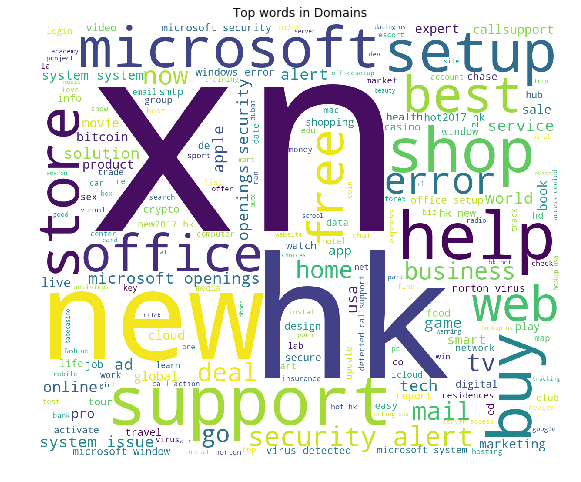

In [27]:
# Wordcloud for TOP Domain names found in our train data

from wordcloud import WordCloud
plt.figure(figsize = (12, 8))
text = ' '.join(df_train.domain.values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in Domains')
plt.axis("off")
plt.show()

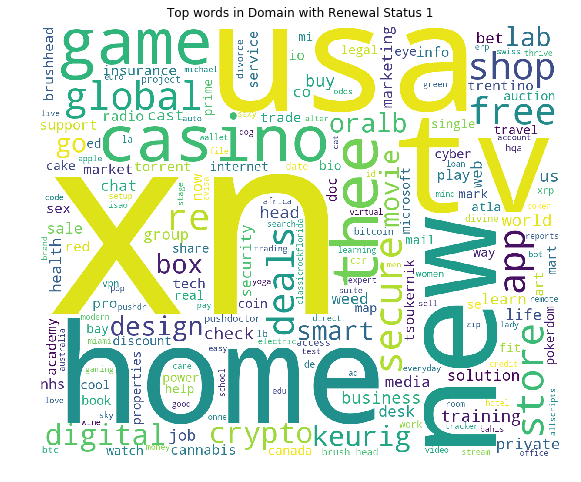

In [28]:
# # wordcloud for Cases with Renewal Status as 1 (Renewed)
renewal_status_1 = df_train.loc[df_train['renewal_status'] == 1]

plt.figure(figsize = (12, 8))
text = ' '.join(renewal_status_1['domain'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in Domain with Renewal Status 1')
plt.axis("off")
plt.show()

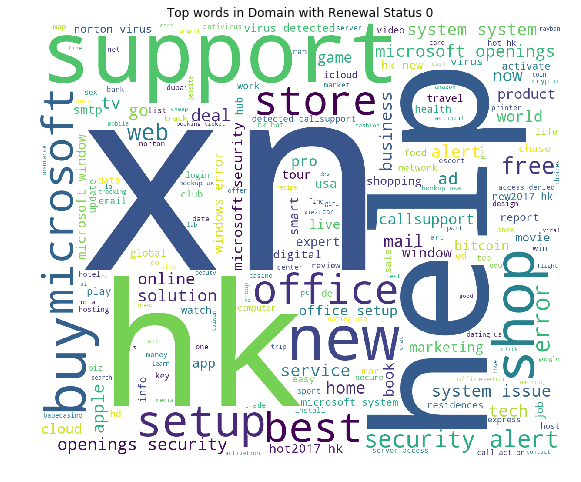

In [29]:
# # wordcloud for Cases with Renewal Status as 0 (Not Renewed)
renewal_status_0 = df_train.loc[df_train['renewal_status'] == 0]

plt.figure(figsize = (12, 8))
text = ' '.join(renewal_status_0['domain'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in Domain with Renewal Status 0')
plt.axis("off")
plt.show()

In [30]:
### Function to Find whether a word is Gibberish or Valid Word without dictionary lookup
from __future__ import division
import re
import math


def split_in_chunks(text, chunk_size):
    chunks = []
    for i in range(0, len(text), chunk_size):
        chunks.append(text[i:i + chunk_size])
    if len(chunks) > 1 and len(chunks[-1]) < 10:
        chunks[-2] += chunks[-1]
        chunks.pop(-1)
    return chunks


def unique_chars_per_chunk_percentage(text, chunk_size):
    chunks = split_in_chunks(text, chunk_size)
    unique_chars_percentages = []
    for chunk in chunks:
        total = len(chunk)
        unique = len(set(chunk))
        unique_chars_percentages.append(unique / total)
    return sum(unique_chars_percentages) / len(unique_chars_percentages) * 100


def vowels_percentage(text):
    vowels = 0
    total = 0
    for c in text:
        if not c.isalpha():
            continue
        total += 1
        if c in "aeiouAEIOU":
            vowels += 1
    if total != 0:
        return vowels / total * 100
    else:
        return 0


def word_to_char_ratio(text):
    chars = len(text)
    words = len([x for x in re.split(r"[\W_]", text) if x.strip() != ""])
    return words / chars * 100


def deviation_score(percentage, lower_bound, upper_bound):
    if percentage < lower_bound:
        return math.log(lower_bound - percentage, lower_bound) * 100
    elif percentage > upper_bound:
        return math.log(percentage - upper_bound, 100 - upper_bound) * 100
    else:
        return 0


def classify(text):
    if text is None or len(text) == 0:
        return 0.0
    ucpcp = unique_chars_per_chunk_percentage(text, 35)
    vp = vowels_percentage(text)
    wtcr = word_to_char_ratio(text)

    ucpcp_dev = max(deviation_score(ucpcp, 45, 50), 1)
    vp_dev = max(deviation_score(vp, 35, 45), 1)
    wtcr_dev = max(deviation_score(wtcr, 15, 20), 1)

    return max((math.log10(ucpcp_dev) + math.log10(vp_dev) +
                math.log10(wtcr_dev)) / 6 * 100, 1)

In [31]:
df_train['GibberishOrNot'] = df_train.domain.apply(classify)
df_test['GibberishOrNot'] = df_test.domain.apply(classify)

In [32]:
### Feature Engineer new variables from Domain Names 
complete_data = [df_train, df_test]

for data in complete_data:
    ## Number of words in the Domain ##
    data["Domain_num_words"] = data["domain"].apply(lambda x: len(str(x)))

    ## Number of Digits in the Domain ##
    data["Domain_num_words_digit"] = data["domain"].apply(lambda x: len([w for w in str(x) if w.isdigit()]))

    ## Number of Alphabetical Words in the Domain ##
    data["Domain_num_words_aplha"] = data["domain"].apply(lambda x: len([w for w in str(x) if w.isalpha()]))

    ## Number of Identifier words in the Domain ##
    data["Domain_num_words_identifier"] = data["domain"].apply(lambda x: len([w for w in str(x) if w.isidentifier()]))
    
    ## Number of Alphanumeric words in the Domain ##
    data["Domain_num_words_alnum"] = data["domain"].apply(lambda x: len([w for w in str(x) if w.isalnum()]))
    
    ## Number of characters in the Domain ##
    data["Domain_num_chars"] = data["domain"].apply(lambda x: len(str(x)))

    ## Number of stopwords in the Domain ##
    data["Domain_num_stopwords"] = data["domain"].apply(lambda x: len([w for w in str(x).lower() if w in stop_words]))

    ## Number of punctuations in the Domain ##
    data["Domain_num_punctuations"] =data['domain'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [33]:
df_train.columns

Index(['domain', 'expiry_date', 'creation_date', 'registrant_country',
       'renewal_status', 'reg_price', 'GibberishOrNot', 'Domain_num_words',
       'Domain_num_words_digit', 'Domain_num_words_aplha',
       'Domain_num_words_identifier', 'Domain_num_words_alnum',
       'Domain_num_chars', 'Domain_num_stopwords', 'Domain_num_punctuations'],
      dtype='object')

In [34]:
df_train.head()

,domain,expiry_date,creation_date,registrant_country,renewal_status,reg_price,GibberishOrNot,Domain_num_words,Domain_num_words_digit,Domain_num_words_aplha,Domain_num_words_identifier,Domain_num_words_alnum,Domain_num_chars,Domain_num_stopwords,Domain_num_punctuations
0,lisandro,2017-01-01,2016-01-01,Brazil,0,5.0,58.822943,8,0,8,8,8,8,5,0
1,globalcapaci,2017-01-01,2016-01-01,Panama,0,5.0,61.704497,12,0,12,12,12,12,5,0
2,creighton,2017-01-01,2016-01-01,United States,0,5.0,80.961218,9,0,9,9,9,9,3,0
3,thecitadel,2017-01-01,2016-01-01,United States,0,5.0,61.887466,10,0,10,10,10,10,5,0
4,lesbiantoys,2017-01-01,2016-01-01,United States,0,5.0,63.233955,11,0,11,11,11,11,7,0


# Date Columns - Feature Engineering

In [35]:
################### Date conversion - Feature Engineering ###################
def seasons(x):
    ''' for seasons in a year using month column'''
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

def week(x):
    ''' for week:weekday/weekend in a day_of_week column '''
    if (x >=0) and (x <= 4):
        return 'weekday'
    elif (x >=5) and (x <=6 ):
        return 'weekend'

In [36]:
## Deriving new values like year, month, day_of_the_week, season, week from date
complete_data = [df_train, df_test]
for data in complete_data:
    for col in ['expiry_date', 'creation_date']:
        data[col+"_year"] = data[col].apply(lambda row: row.year)
        data[col+"_month"] = data[col].apply(lambda row: row.month)
        data[col+"_day_of_week"] = data[col].apply(lambda row: row.dayofweek)
        data[col+'_seasons'] = data[col+"_month"].apply(seasons)
        data[col+'_week'] = data[col+"_day_of_week"].apply(week)

In [37]:
# Create new variable which takes into account the difference between expiry date and creation Date
df_train['Diff_Days_Expiry_Creation'] = df_train['expiry_date'] - df_train['creation_date']
df_train['Diff_Days_Expiry_Creation'] = df_train['Diff_Days_Expiry_Creation']/np.timedelta64(1,'D')

In [38]:
# Create new variable which takes into account the difference between expiry date and creation Date
df_test['Diff_Days_Expiry_Creation'] = df_test['expiry_date'] - df_train['creation_date']
df_test['Diff_Days_Expiry_Creation'] = df_test['Diff_Days_Expiry_Creation']/np.timedelta64(1,'D')

In [39]:
categorical_columns = ['registrant_country', 'expiry_date_year','expiry_date_month', 'expiry_date_day_of_week', 'expiry_date_seasons',
       'expiry_date_week', 'creation_date_year', 'creation_date_month','creation_date_day_of_week', 'creation_date_seasons','creation_date_week']

#numerical_columns = [x for x in df_train.columns if x not in categorical_columns]

numerical_columns = ['reg_price',
                     'GibberishOrNot',
                     'Domain_num_words',
                     'Domain_num_words_digit',
                     'Domain_num_words_aplha',
                     'Domain_num_words_identifier',
                     'Domain_num_words_alnum',
                     'Domain_num_chars',
                     'Domain_num_stopwords',
                     'Domain_num_punctuations',
                     'Diff_Days_Expiry_Creation']

# Graphical Visualization of Data

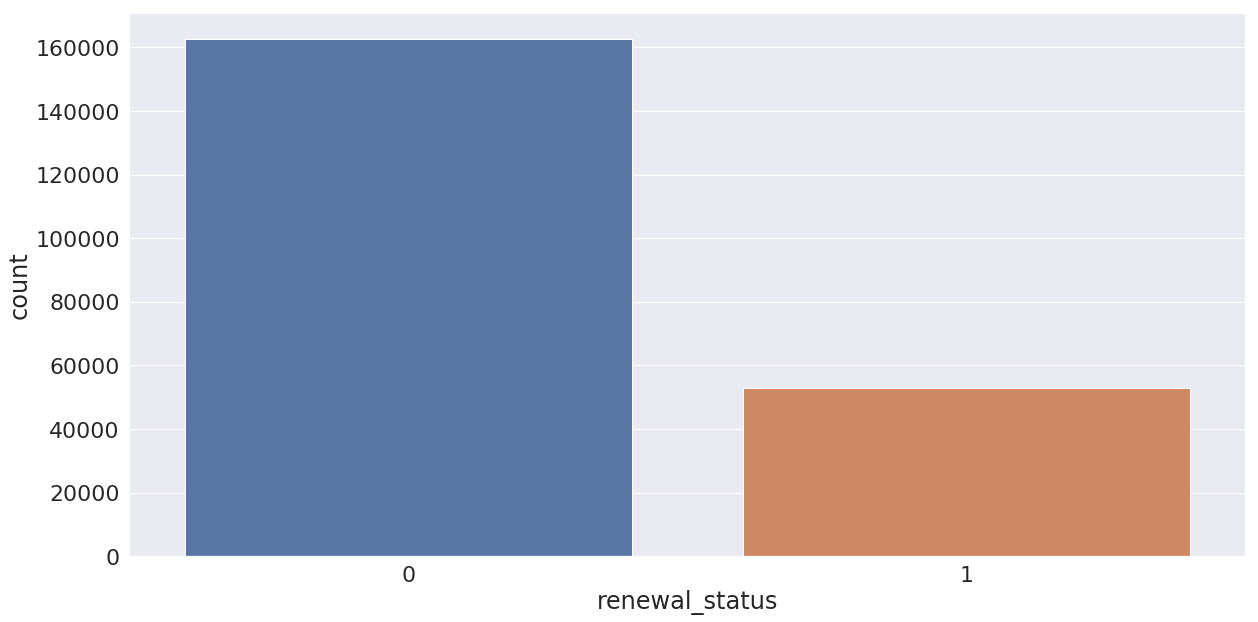

In [40]:
############## Graphical Exploratory Data Analysis ##############
plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
sns.countplot(df_train.renewal_status)

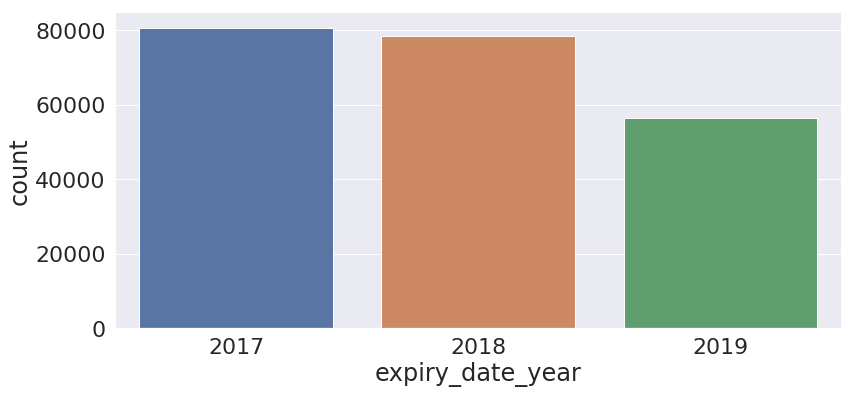

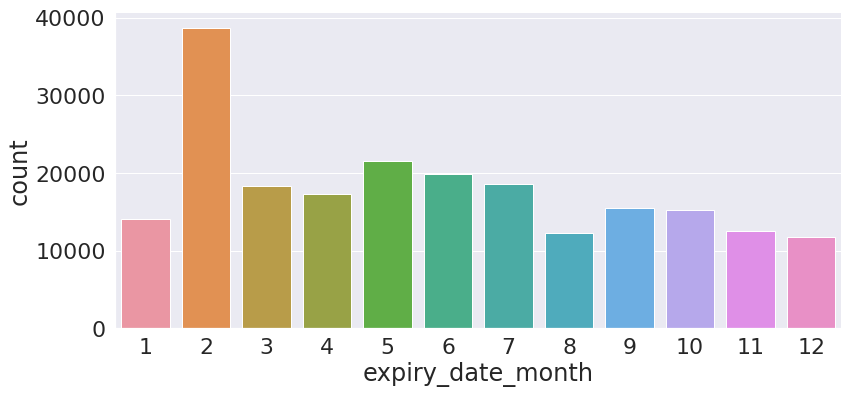

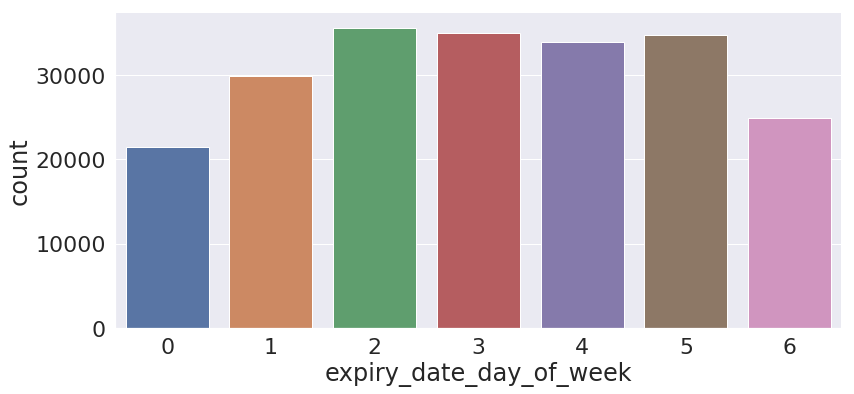

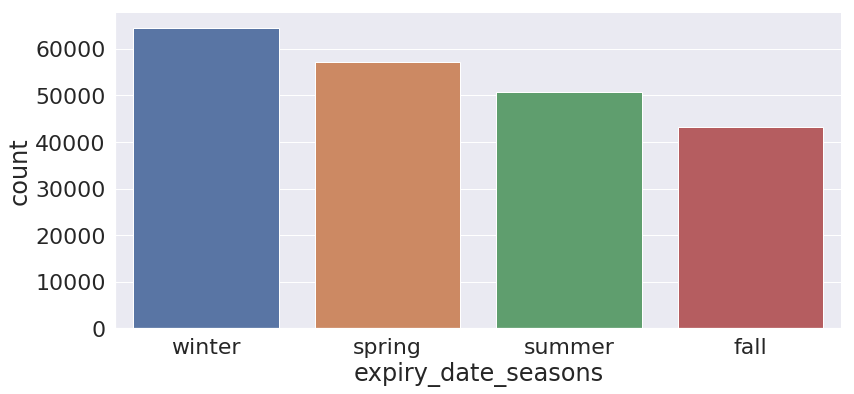

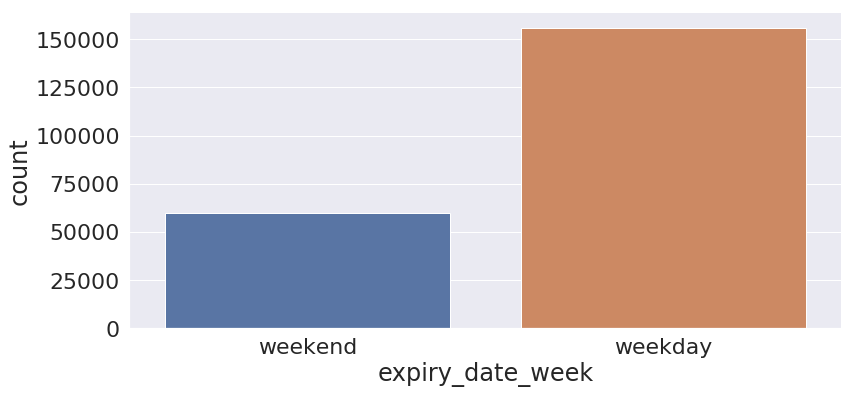

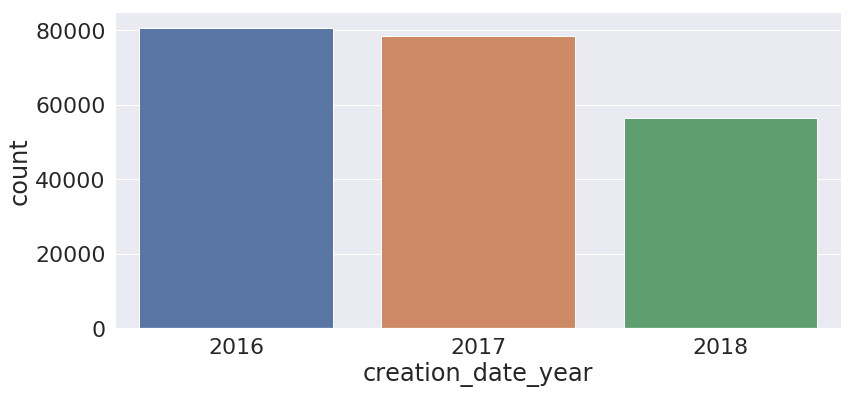

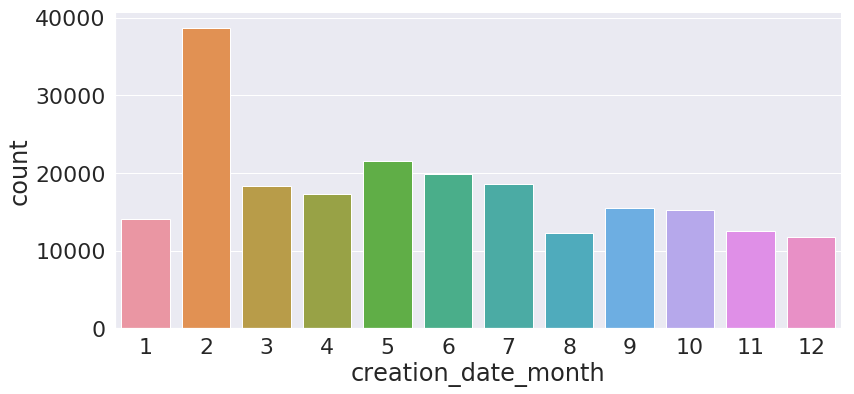

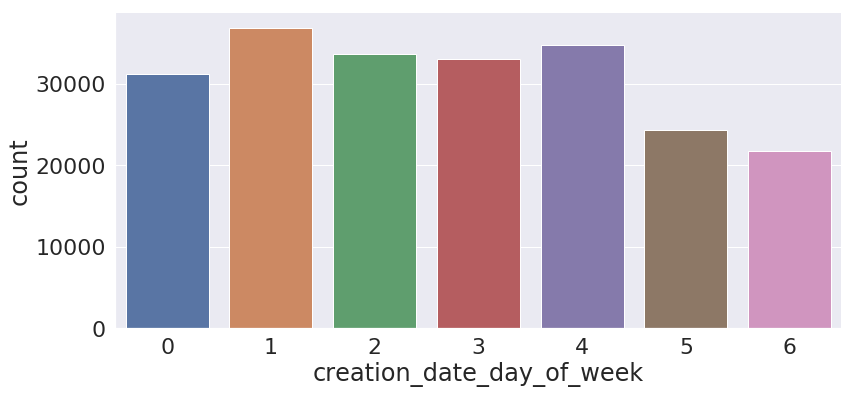

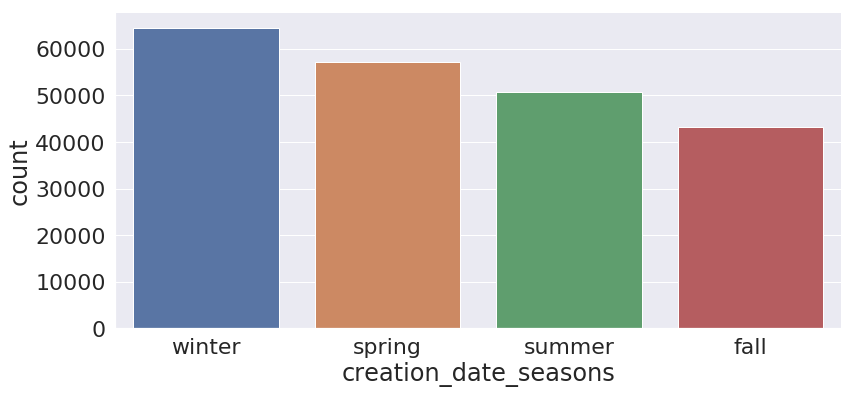

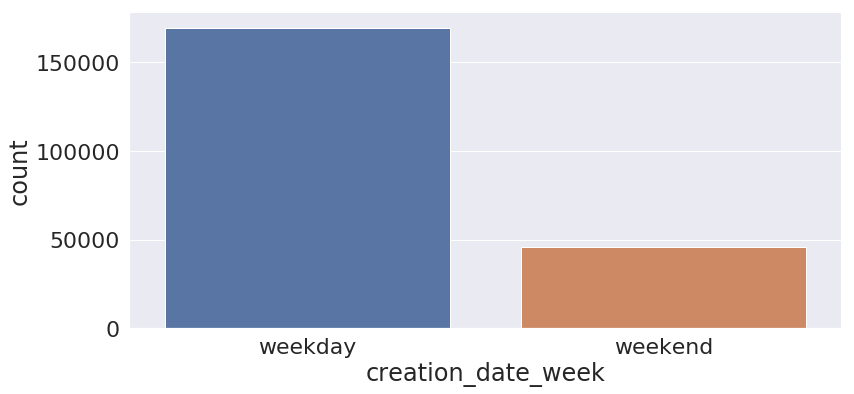

In [41]:
# Frequency Countplot for Categorical variable
for i in categorical_columns:
    if i == "registrant_country":
        continue
    sns.factorplot(data=df_train, x=i ,kind='count', size=6, aspect=2)

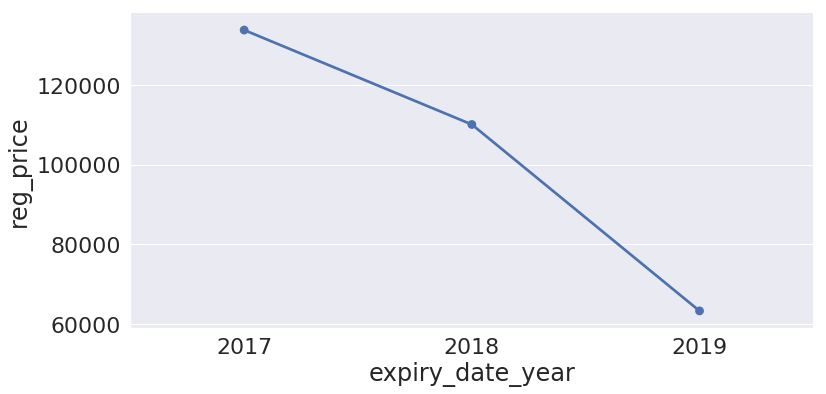

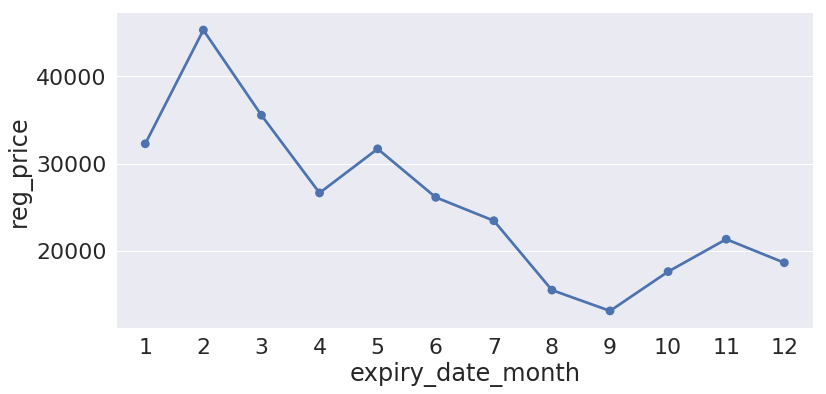

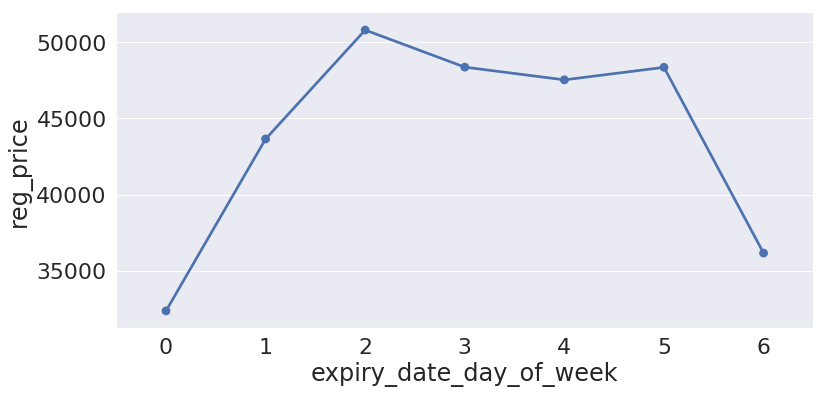

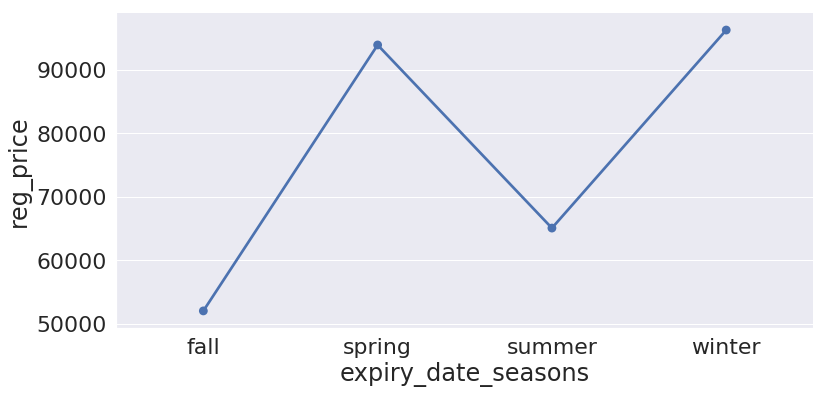

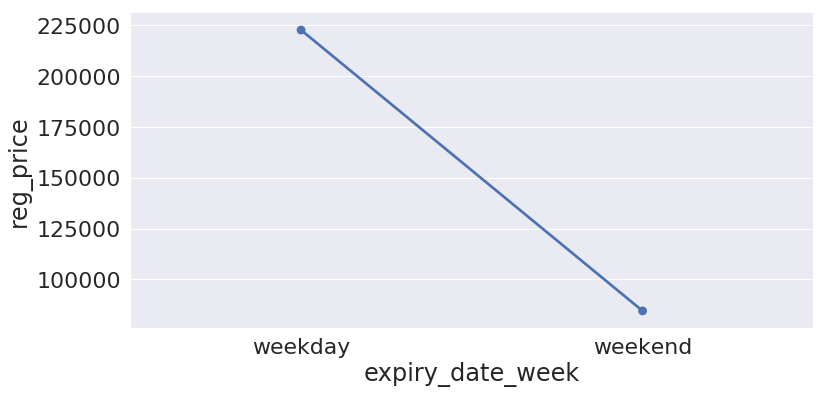

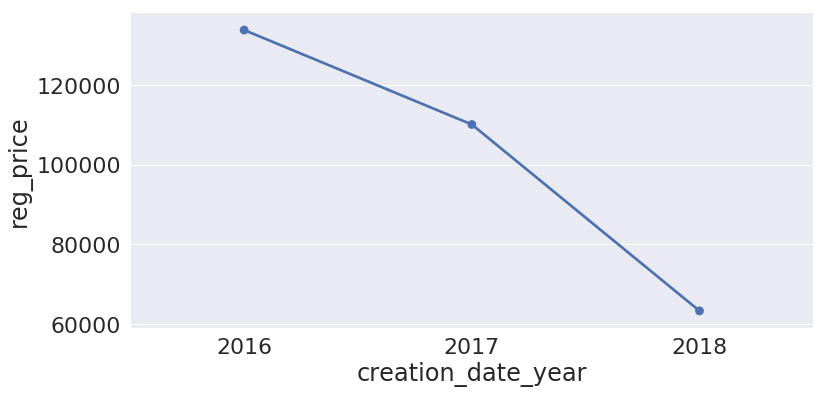

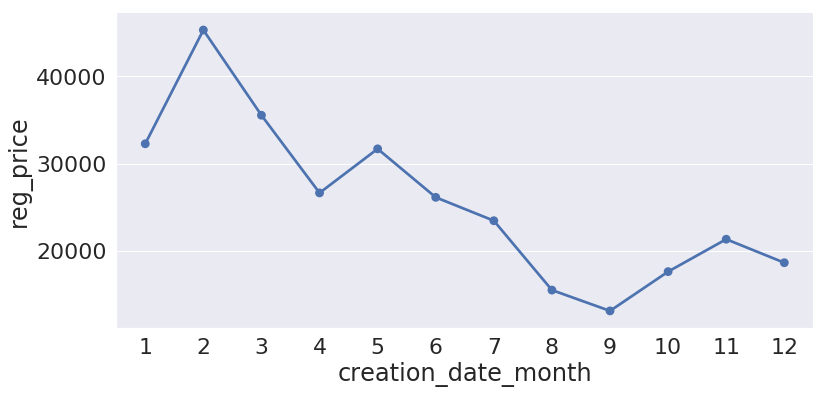

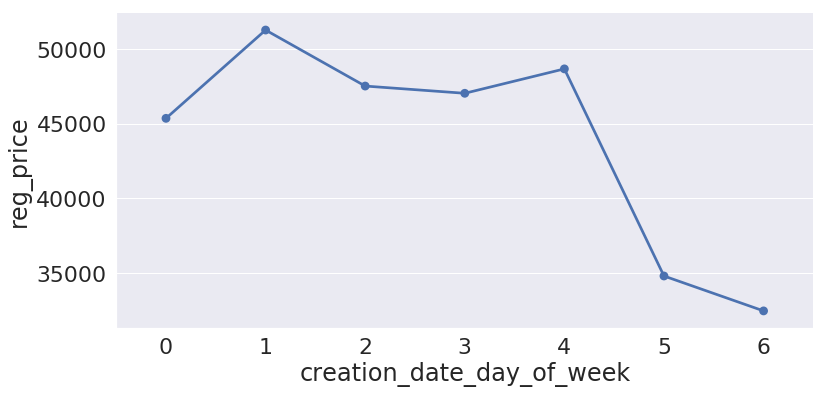

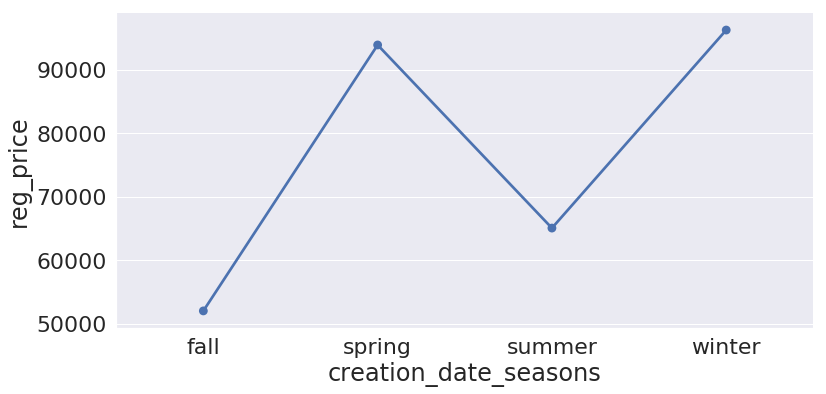

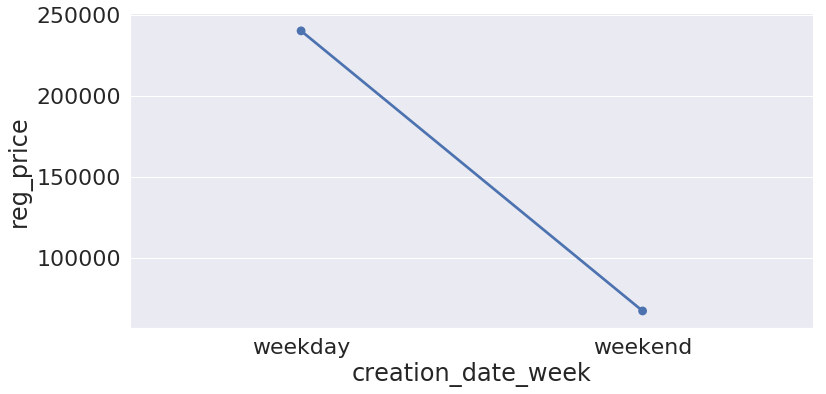

In [42]:
# Bivariate Analysis of all categorical variables with Target Variable.
for col in categorical_columns:
    if col == "registrant_country":
        continue
    df_cat = pd.DataFrame(df_train.groupby([col], as_index=False).sum())
    sns.catplot(x=col, y="reg_price", data=df_cat.reset_index(), kind="point", height=6, aspect=2)

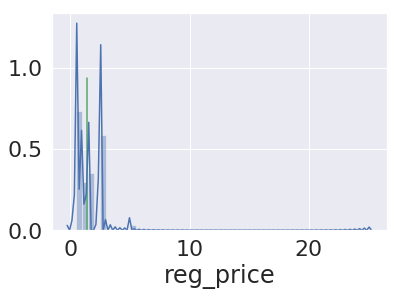

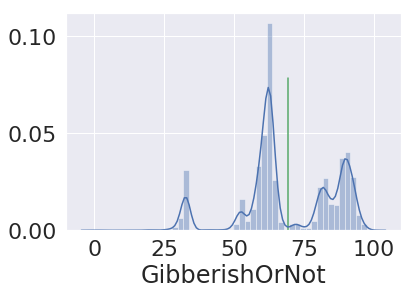

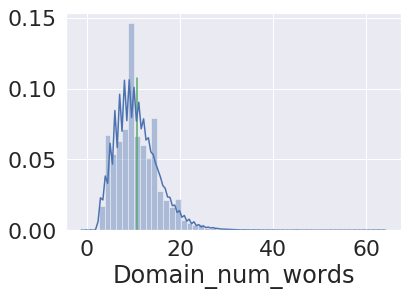

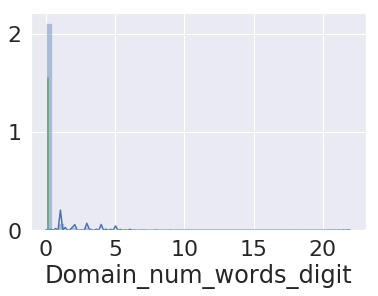

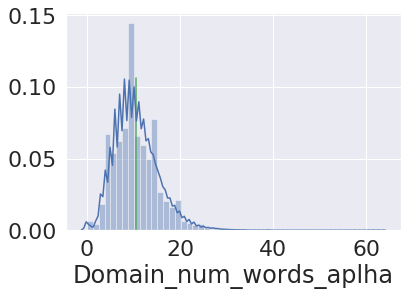

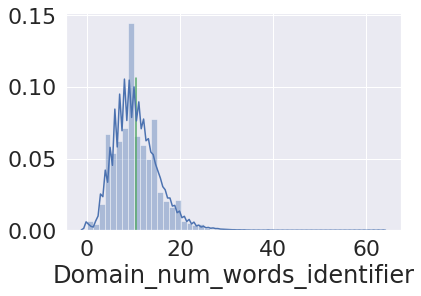

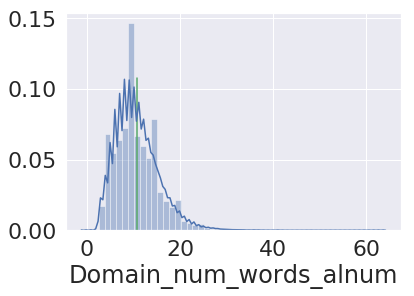

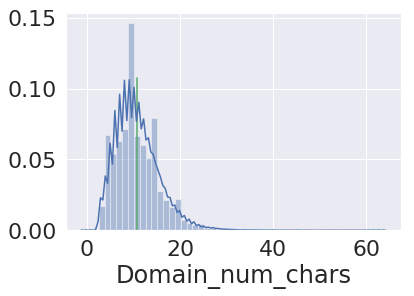

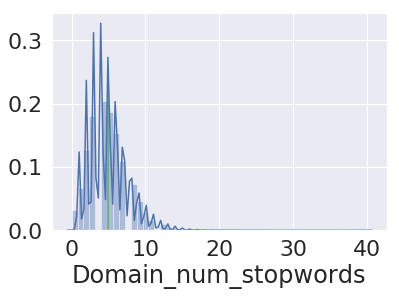

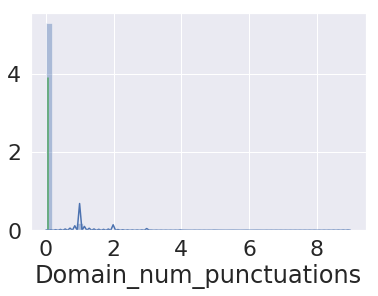

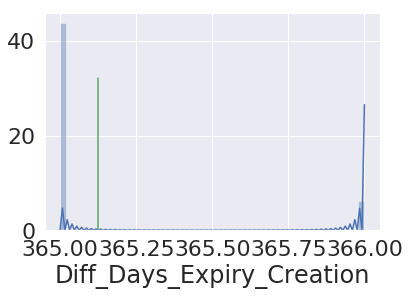

In [43]:
# Histogram - Distribution plot for all continous variables
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    plt.axvline(df_train[col].mean(), 0,0.7, color = 'g')
    sns.distplot(df_train[col], color = 'b')

# Statistical Tests for Checking Correlation and Dependence

In [44]:
# Create df from continous variables
df_corr = df_train.loc[:,numerical_columns]

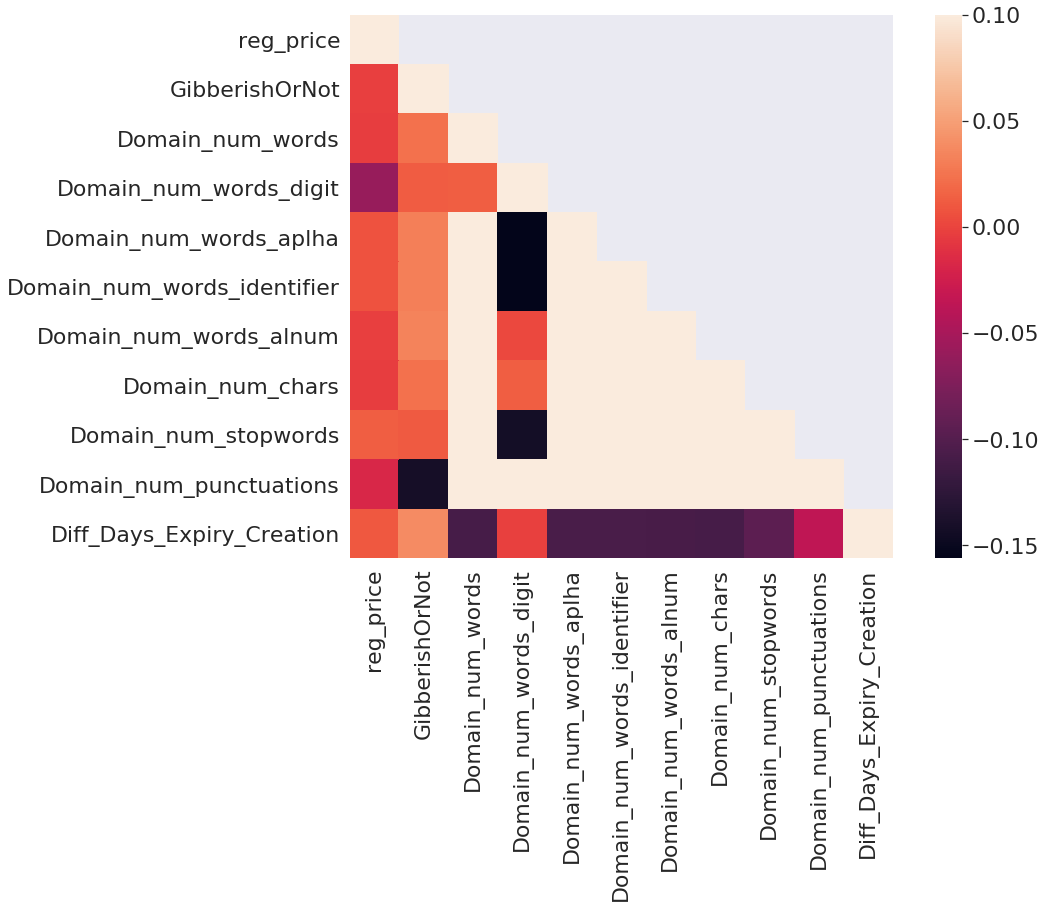

In [45]:
# Corelation graph for checking Multicollinearity for continous variables
f, ax = plt.subplots(figsize=(15, 10))

#Generate correlation matrix
corr = df_corr.corr()

#Plot heatmap using seaborn library
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
ax = sns.heatmap(corr, mask=mask, vmax=.1, square=True, annot=False, ax=ax)

# We will have l2 regularization for automatically removing all the highly correlated features

In [46]:
#loop for ANOVA test for checking dependancy of categorical and numerical data Type
for i in numerical_columns:
    f, p = stats.f_oneway(df_train.renewal_status, df_train[i])
    print("P value for variable "+str(i)+" is "+str(p))

P value for variable reg_price is 0.0
P value for variable GibberishOrNot is 0.0
P value for variable Domain_num_words is 0.0
P value for variable Domain_num_words_digit is 8.335414019227774e-296
P value for variable Domain_num_words_aplha is 0.0
P value for variable Domain_num_words_identifier is 0.0
P value for variable Domain_num_words_alnum is 0.0
P value for variable Domain_num_chars is 0.0
P value for variable Domain_num_stopwords is 0.0
P value for variable Domain_num_punctuations is 0.0
P value for variable Diff_Days_Expiry_Creation is 0.0


# GLoVe - Word Embedding for Domain Feature

In [47]:
# # load the GloVe vectors in a dictionary:
# from tqdm import tqdm
# embeddings_index = {}
# f = open('glove.840B.300d.txt', encoding='utf8')
# for line in tqdm(f):
#     values = line.split(' ')
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

In [48]:
# # this function creates a normalized vector for the whole sentence
# def word2vec(s):
#     words = str(s).lower()
#     words = [w for w in words if w.isalpha()]
#     words = [w for w in words if w not in string.punctuation]
#     M = []
#     for w in words:
#         try:
#             M.append(embeddings_index[w])
#         except:
#             continue
#     M = np.array(M)
#     v = M.sum(axis=0)
#     if type(v) != np.ndarray:
#         return np.zeros(300)
#     return v / np.sqrt((v ** 2).sum())

In [49]:
# xtrain_glove = [word2vec(x) for x in tqdm(df_train['domain'].values)]
# xtest_glove = [word2vec(x) for x in tqdm(df_test['domain'].values)]

In [50]:
# xtrain_glove = pd.DataFrame(np.array(xtrain_glove))
# xtest_glove = pd.DataFrame(np.array(xtest_glove))

# print(xtrain_glove.shape)

In [51]:
# xtrain_glove.columns = ['glove_syn_'+str(i) for i in range(300)]
# xtest_glove.columns = ['glove_syn_'+str(i) for i in range(300)]

# df_train = pd.concat([df_train, xtrain_glove], axis=1)
# df_test = pd.concat([df_test, xtest_glove], axis=1)

In [52]:
df_train.columns

Index(['domain', 'expiry_date', 'creation_date', 'registrant_country',
       'renewal_status', 'reg_price', 'GibberishOrNot', 'Domain_num_words',
       'Domain_num_words_digit', 'Domain_num_words_aplha',
       'Domain_num_words_identifier', 'Domain_num_words_alnum',
       'Domain_num_chars', 'Domain_num_stopwords', 'Domain_num_punctuations',
       'expiry_date_year', 'expiry_date_month', 'expiry_date_day_of_week',
       'expiry_date_seasons', 'expiry_date_week', 'creation_date_year',
       'creation_date_month', 'creation_date_day_of_week',
       'creation_date_seasons', 'creation_date_week',
       'Diff_Days_Expiry_Creation'],
      dtype='object')

In [53]:
# Drop Date Columns and domain since we've extracted all possible information from them 
df_train = df_train.drop(['domain', 'expiry_date', 'creation_date'], axis = 1)
df_test =  df_test.drop(['domain','expiry_date','creation_date'], axis=1)

In [54]:
df_train.shape

(215608, 23)

In [55]:
df_train.dtypes

registrant_country             category
renewal_status                    int64
reg_price                       float64
GibberishOrNot                  float64
Domain_num_words                  int64
Domain_num_words_digit            int64
Domain_num_words_aplha            int64
Domain_num_words_identifier       int64
Domain_num_words_alnum            int64
Domain_num_chars                  int64
Domain_num_stopwords              int64
Domain_num_punctuations           int64
expiry_date_year                  int64
expiry_date_month                 int64
expiry_date_day_of_week           int64
expiry_date_seasons              object
expiry_date_week                 object
creation_date_year                int64
creation_date_month               int64
creation_date_day_of_week         int64
creation_date_seasons            object
creation_date_week               object
Diff_Days_Expiry_Creation       float64
dtype: object

# One Hot Encoding For Categorical Data

In [56]:
# One hot Encoding
temp = pd.get_dummies(pd.concat([df_train, df_test], keys=[0,1]), columns=categorical_columns)

# # Selecting data from multi index and assigning them i.e
df_train,df_test = temp.xs(0),temp.xs(1)

In [57]:
df_train.columns

Index(['renewal_status', 'reg_price', 'GibberishOrNot', 'Domain_num_words',
       'Domain_num_words_digit', 'Domain_num_words_aplha',
       'Domain_num_words_identifier', 'Domain_num_words_alnum',
       'Domain_num_chars', 'Domain_num_stopwords',
       ...
       'creation_date_day_of_week_3', 'creation_date_day_of_week_4',
       'creation_date_day_of_week_5', 'creation_date_day_of_week_6',
       'creation_date_seasons_fall', 'creation_date_seasons_spring',
       'creation_date_seasons_summer', 'creation_date_seasons_winter',
       'creation_date_week_weekday', 'creation_date_week_weekend'],
      dtype='object', length=280)

# Model Development

In [58]:
######################## Model Building #####################
X_train = df_train.iloc[:, df_train.columns != 'renewal_status'].values
y_train = df_train['renewal_status'].values

# Class Imbalance - OverSampling

In [59]:
############# Class Imbalance  - OverSampling #####################
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

Using TensorFlow backend.


In [60]:
np.bincount(y_train)

array([162779, 162779])

# Random Forest

In [79]:
############################# Random Forest ############################

# import the ML algorithm
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
rfModel = RandomForestClassifier(n_estimators=100)

# Train classifier
rfModel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
# Do Prediction
y_pred_rf = rfModel.predict(df_test.iloc[:, df_test.columns != 'renewal_status'].values)

In [81]:
###################################### Evaluation Metrics ###############################################
y = df_test['renewal_status'].values

print("Confusion Matrix : ",end='\n')
print(confusion_matrix(y, y_pred_rf))
   
print('Accuracy : ', accuracy_score(y, y_pred_rf), end='\n')
    
print('Classification Report : ', end='\n')
print(classification_report(y, y_pred_rf))

Confusion Matrix : 
[[13980  1967]
 [  837   184]]
Accuracy :  0.8347477604903347
Classification Report : 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     15947
           1       0.09      0.18      0.12      1021

   micro avg       0.83      0.83      0.83     16968
   macro avg       0.51      0.53      0.51     16968
weighted avg       0.89      0.83      0.86     16968



# XGBoost

In [ ]:
# import the ML algorithm
from xgboost import XGBClassifier

# Instantiate the classifier
xgbClassifier = XGBClassifier(random_state=1,learning_rate=0.01)

# Train classifier
xgbClassifier.fit(X_train, y_train)

In [73]:
# Do Prediction
y_pred_xgb = xgbClassifier.predict(df_test.iloc[:, df_test.columns != 'renewal_status'].values)

In [74]:
###################################### Evaluation Metrics ###############################################
y = df_test['renewal_status'].values

print("Confusion Matrix : ",end='\n')
print(confusion_matrix(y, y_pred_xgb))
   
print('Accuracy : ', accuracy_score(y, y_pred_xgb), end='\n')
    
print('Classification Report : ', end='\n')
print(classification_report(y, y_pred_xgb))

################## Best Model ################

Confusion Matrix : 
[[15644   303]
 [  965    56]]
Accuracy :  0.9252710985384253
Classification Report : 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     15947
           1       0.16      0.05      0.08      1021

   micro avg       0.93      0.93      0.93     16968
   macro avg       0.55      0.52      0.52     16968
weighted avg       0.89      0.93      0.91     16968



# Neural Networks

In [83]:
from keras.models import Sequential
from keras.layers import Dense

In [88]:
# Create Keras model
model = Sequential()
model.add(Dense(100, input_dim=279, activation="relu"))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [89]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [92]:
model.fit(X_train, y_train,epochs=30, batch_size=10)

Epoch 1/30
325558/325558 [==============================] - 77s 237us/step - loss: 0.5849 - accuracy: 0.6759
Epoch 2/30
325558/325558 [==============================] - 75s 231us/step - loss: 0.5648 - accuracy: 0.6853
Epoch 3/30
325558/325558 [==============================] - 75s 230us/step - loss: 0.5554 - accuracy: 0.6897
Epoch 4/30
325558/325558 [==============================] - 74s 229us/step - loss: 0.5517 - accuracy: 0.6908
Epoch 5/30
325558/325558 [==============================] - 76s 232us/step - loss: 0.5489 - accuracy: 0.6930
Epoch 6/30
325558/325558 [==============================] - 75s 231us/step - loss: 0.5480 - accuracy: 0.6934
Epoch 7/30
325558/325558 [==============================] - 74s 227us/step - loss: 0.5462 - accuracy: 0.6942
Epoch 8/30
325558/325558 [==============================] - 75s 231us/step - loss: 0.5453 - accuracy: 0.6953
Epoch 9/30
325558/325558 [==============================] - 74s 227us/step - loss: 0.5440 - accuracy: 0.6957
Epoch 10/30
325558/

In [94]:
predictions = model.predict_classes(df_test.iloc[:, df_test.columns != 'renewal_status'].values)

In [95]:
###################################### Evaluation Metrics ###############################################
y = df_test['renewal_status'].values

print("Confusion Matrix : ",end='\n')
print(confusion_matrix(y, predictions))
   
print('Accuracy : ', accuracy_score(y, predictions), end='\n')
    
print('Classification Report : ', end='\n')
print(classification_report(y, predictions))

Confusion Matrix : 
[[10311  5636]
 [  494   527]]
Accuracy :  0.6387317303158887
Classification Report : 
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     15947
           1       0.09      0.52      0.15      1021

   micro avg       0.64      0.64      0.64     16968
   macro avg       0.52      0.58      0.46     16968
weighted avg       0.90      0.64      0.73     16968



# Class Imbalance - UnderSampling

In [96]:
####################### Class Imbalance - Undersampling ######################
X_train = df_train.iloc[:, df_train.columns != 'renewal_status'].values
y_train = df_train['renewal_status'].values


from imblearn.under_sampling import NearMiss
nr = NearMiss()
X_train, y_train = nr.fit_sample(X_train, y_train)

In [97]:
np.bincount(y_train)

array([52829, 52829])

In [98]:
# import the ML algorithm
from xgboost import XGBClassifier

# Instantiate the classifier
xgbClassifier = XGBClassifier(random_state=1,learning_rate=0.01)

# Train classifier
xgbClassifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=1, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [99]:
# Do Prediction
y_pred_xgb = xgbClassifier.predict(df_test.iloc[:, df_test.columns != 'renewal_status'].values)

In [100]:
###################################### Evaluation Metrics ###############################################
y = df_test['renewal_status'].values

print("Confusion Matrix : ",end='\n')
print(confusion_matrix(y, y_pred_xgb))
   
print('Accuracy : ', accuracy_score(y, y_pred_xgb), end='\n')
    
print('Classification Report : ', end='\n')
print(classification_report(y, y_pred_xgb))

Confusion Matrix : 
[[11646  4301]
 [  827   194]]
Accuracy :  0.6977840641206978
Classification Report : 
              precision    recall  f1-score   support

           0       0.93      0.73      0.82     15947
           1       0.04      0.19      0.07      1021

   micro avg       0.70      0.70      0.70     16968
   macro avg       0.49      0.46      0.44     16968
weighted avg       0.88      0.70      0.77     16968



# Saving Best Model -  XGBoost with Oversampled Dataset

In [66]:
# Pickling of Final Classification Model
import pickle
pickle.dump(LogReg, open('final_prediction.pickle', 'wb'))

In [67]:
#### Conclsuion : 

#1) Built a model to predict Domain Renewal with almost 93% Testing Accuracy
#2) Explored through Exploratory Data Analysis and understood the relationship of features.
#3) Built Wordcloud to better understand what are the TOP MOST Domain Name words.
#4) Used statistical analysis (ANOVA, correlation-coefficients) and graphs.
#5) Used Oversampling and Undersampling Technique for overcoming Class Imbalance Problem
#6) Did alot of Feaure Engineering and built new features to assist the model to better understand the patterns inside the data:
    #1) Dervied new features Like Year, Month, Season from Variables including Date (creation_date, expiry_date)
    #2) Reshaped the entire dataset from 8 columns to 580 columns with same rows.
    #3) Applied Textual Preprocessing and cleaning techniques to create features from Domain Names.
    #4) Using NLP - GLoVe Word Embeddings Transformed domain names to respective Vector Representations